<center>
  <h1>Quantitative Analysis of FOMC Policy Impact on U.S. Equity Sectors</h1>
  <p><strong>Author:</strong> Enes Goktas</p>
  <p><strong>Date:</strong> August 4, 2025</p>
</center>

> **_Executive Summary:_** _This project conducts a quantitative event study to measure and analyze the impact of Federal Reserve (FOMC) monetary policy announcements on the U.S. technology (XLK), financial (XLF), and utilities (XLU) sectors. By separating announcements into rate hikes, cuts, and holds, the analysis reveals that market reactions were largely **statistically insignificant** and **counter-intuitive** relative to standard theory. Specifically, the financial sector did **not** benefit from rate hikes, and utilities did not rally during cuts, likely due to broader market volatility overshadowing sector-specific dynamics. However, the technology sector showed a statistically significant positive response to rate cuts, aligning with growth valuation theory._

## 🎯 Problem Statement

Recent years have seen significant shifts in monetary policy by the U.S. Federal Reserve. These decisions, particularly changes to the federal funds rate, are closely watched by investors, but their impact is not uniform across the market. Sectors like financials and utilities are known to be highly sensitive to interest rate changes.

This project seeks to answer the question: **Do Federal Reserve (FOMC) interest rate announcements systematically cause abnormal stock returns in the Technology (XLK), Financials (XLF), and Utilities (XLU) sectors?**

## 📝 Project Objectives

* **Apply Financial Theory:** Understand and quantify the relationship between monetary policy and equity markets.
* **Implement an Event Study:** Conduct a full event study, from data gathering to statistical analysis, a core methodology in empirical finance.
* **Develop Quantitative Skills:** Gain proficiency in Python for financial data analysis using `pandas`, `statsmodels`, and `yfinance`.
* **Communicate Findings:** Learn to interpret and present quantitative results clearly, a crucial skill for any finance role.

## 1. Setup

First, we'll import the necessary Python libraries and define the key parameters for our study, including the stock tickers, the date range for our analysis, and the dates of the FOMC announcements.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style('whitegrid')

# Define key parameters
ANALYSIS_TICKERS = ['XLK', 'XLF', 'XLU'] # Tech, Financials, Utilities
MARKET_BENCHMARK = 'SPY' # S&P 500
START_DATE = '2019-01-01'
END_DATE = '2025-08-01' # Use a future date to ensure we get the latest data
EVENT_WINDOW = [-1, 0, 1] # Day before, day of, and day after the event

# FOMC announcement dates (Source: federalreserve.gov/monetarypolicy/fomccalendars.htm)
# List includes only completed meetings as of the current date (August 4, 2025).
FOMC_DATES = pd.to_datetime([
    # 2019
    '2019-01-30', '2019-03-20', '2019-05-01', '2019-06-19',
    '2019-07-31', '2019-09-18', '2019-10-30', '2019-12-11',
    # 2020
    '2020-01-29',
    '2020-03-03',  # Unscheduled emergency meeting
    '2020-03-15',  # Unscheduled emergency meeting
    '2020-04-29', '2020-06-10', '2020-07-29', '2020-09-16',
    '2020-11-05', '2020-12-16',
    # 2021
    '2021-01-27', '2021-03-17', '2021-04-28', '2021-06-16',
    '2021-07-28', '2021-09-22', '2021-11-03', '2021-12-15',
    # 2022
    '2022-01-26', '2022-03-16', '2022-05-04', '2022-06-15',
    '2022-07-27', '2022-09-21', '2022-11-02', '2022-12-14',
    # 2023
    '2023-02-01', '2023-03-22', '2023-05-03', '2023-06-14',
    '2023-07-26', '2023-09-20', '2023-11-01', '2023-12-13',
    # 2024
    '2024-01-31', '2024-03-20', '2024-05-01', '2024-06-12',
    '2024-07-31', '2024-09-18', '2024-11-07', '2024-12-18',
    # 2025
    '2025-01-29', '2025-03-19', '2025-04-30', '2025-06-11',
    '2025-07-30'
])

## 2. Data Collection & Preparation

Next, we'll download historical stock prices using the `yfinance` library. Once we have the price data, we will calculate the daily logarithmic returns, which are standard for financial analysis. The formula is: $R = \ln(\text{Price}_t / \text{Price}_{t-1})$.

In [ ]:
# Download historical adjusted closing prices from Yahoo Finance
print("Downloading historical stock data...")

# Combine the analysis tickers with the benchmark for the download
TICKERS_TO_DOWNLOAD = ANALYSIS_TICKERS + [MARKET_BENCHMARK]

try:
    # Explicitly set auto_adjust=True to get a clean DataFrame of adjusted close prices
    data = yf.download(
        TICKERS_TO_DOWNLOAD,
        start=START_DATE,
        end=END_DATE,
        auto_adjust=True
    )

    if data.empty:
        raise ValueError("No data downloaded. Check tickers and date range.")

    # yfinance with auto_adjust=True returns ONLY the close prices, so we can
    # calculate the returns directly.
    print("Calculating daily log returns...")
    log_returns = np.log(data['Close'] / data['Close'].shift(1)).dropna()

    # Display the first few rows of the returns data to verify
    print("Data preparation complete. Sample of log returns:")
    print(log_returns.head())

except Exception as e:
    print(f"An error occurred: {e}")

[*********************100%***********************]  4 of 4 completed

Calculating daily log returns...
Data preparation complete. Sample of log returns:
Ticker           SPY       XLF       XLK       XLU
Date                                              
2019-01-03 -0.024152 -0.022738 -0.051785 -0.000192
2019-01-04  0.032947  0.032680  0.043366  0.014699
2019-01-07  0.007854  0.001236  0.008903 -0.006845
2019-01-08  0.009352  0.000823  0.008346  0.012326
2019-01-09  0.004663  0.004924  0.012862 -0.006049


## 3. Event Study Analysis

This is the core of our project. For each sector ETF and for each FOMC announcement date, we will perform the following steps:
1.  **Define Estimation Period**: Select a time window (e.g., 252 trading days) _before_ the event to serve as a baseline.
2.  **Estimate Normal Returns**: Use the Capital Asset Pricing Model (CAPM) to determine the expected return of the stock based on market returns. The model is: _Stock Return = α + β * Market Return_. We will estimate _α_ (alpha) and _β_ (beta) using a regression on the estimation period data.
3.  **Calculate Abnormal Returns**: For each day in our _event window_, we calculate the abnormal return using the formula: _Abnormal Return = Actual Return - Expected (Normal) Return_.

In [ ]:
print("Performing event study calculations...")
all_abnormal_returns = []

# Loop through each event date
for event_date in FOMC_DATES:
    # Define the estimation period
    estimation_end = event_date - pd.Timedelta(days=30)
    estimation_start = estimation_end - pd.Timedelta(days=252)
    estimation_data = log_returns.loc[estimation_start:estimation_end]

    if len(estimation_data) < 20: continue

    # Loop through each sector ETF
    for ticker in ANALYSIS_TICKERS:
        # Prepare data for OLS regression
        Y = estimation_data[ticker]
        X = sm.add_constant(estimation_data[MARKET_BENCHMARK])

        # Run the OLS regression
        model = sm.OLS(Y, X, missing='drop').fit()
        alpha, beta = model.params

        # Calculate abnormal returns during the event window
        for day in EVENT_WINDOW:
            current_date = event_date + pd.Timedelta(days=day)
            if current_date not in log_returns.index: continue

            actual_return = log_returns.loc[current_date, ticker]
            market_return = log_returns.loc[current_date, MARKET_BENCHMARK]

            # Calculate expected and abnormal returns
            expected_return = alpha + beta * market_return
            abnormal_return = actual_return - expected_return

            # Append the results to our list
            all_abnormal_returns.append({
                'ticker': ticker,
                'event_date': event_date,
                'day': day,
                'abnormal_return': abnormal_return
            })

# Convert the list of results into a DataFrame
ar_df = pd.DataFrame(all_abnormal_returns)
print("Event study calculation complete.")
print("Sample of abnormal returns data:")
print(ar_df.head())

Performing event study calculations...
Event study calculation complete.
Sample of abnormal returns data:
  ticker event_date  day  abnormal_return
0    XLK 2019-03-20   -1         0.002894
1    XLK 2019-03-20    0         0.002972
2    XLK 2019-03-20    1         0.009332
3    XLF 2019-03-20   -1        -0.008239
4    XLF 2019-03-20    0        -0.018382


## 4. Initial Results from General Analysis

Here, we will aggregate the results to see the average effect across all events combined.
1.  **Average Abnormal Return (AAR)**: Calculate the average of all abnormal returns for each relative day in the event window.
2.  **Cumulative Abnormal Return (CAR)**: Sum up the AARs to see the total impact over the event window.
3.  **Visualization & Statistical Test**: Plot the CAR and perform a t-test to check for statistical significance.

Calculating Average Abnormal Returns (AAR)...
Calculating Cumulative Abnormal Returns (CAR)...

Plotting Cumulative Abnormal Returns (CAR)...


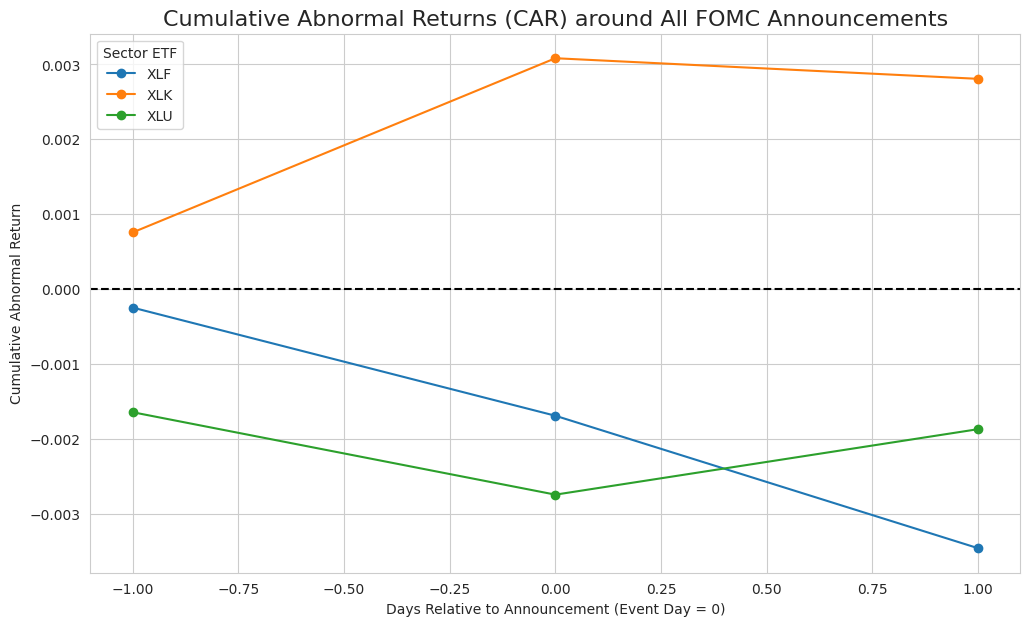


--- T-Test Results for Statistical Significance (All Events) ---

--- XLK ---
Day -1: Avg Abnormal Return = 0.0758%, P-Value = 0.4312
Day  0: Avg Abnormal Return = 0.2324%, P-Value = 0.0280
Day  1: Avg Abnormal Return = -0.0275%, P-Value = 0.7903

--- XLF ---
Day -1: Avg Abnormal Return = -0.0245%, P-Value = 0.8609
Day  0: Avg Abnormal Return = -0.1443%, P-Value = 0.1998
Day  1: Avg Abnormal Return = -0.1767%, P-Value = 0.2255

--- XLU ---
Day -1: Avg Abnormal Return = -0.1640%, P-Value = 0.3077
Day  0: Avg Abnormal Return = -0.1100%, P-Value = 0.4480
Day  1: Avg Abnormal Return = 0.0874%, P-Value = 0.7176


In [ ]:
# Calculate the average abnormal return for each ticker and day
print("Calculating Average Abnormal Returns (AAR)...")
average_ar = ar_df.groupby(['ticker', 'day'])['abnormal_return'].mean()

# Calculate the Cumulative Abnormal Return (CAR)
print("Calculating Cumulative Abnormal Returns (CAR)...")
car = average_ar.unstack(level=0).cumsum()

# Plot the CAR
print("\nPlotting Cumulative Abnormal Returns (CAR)...")
car.plot(figsize=(12, 7), marker='o')
plt.title('Cumulative Abnormal Returns (CAR) around All FOMC Announcements', fontsize=16)
plt.ylabel('Cumulative Abnormal Return')
plt.xlabel('Days Relative to Announcement (Event Day = 0)')
plt.axhline(0, color='black', linestyle='--')
plt.legend(title='Sector ETF')
plt.show()

# Perform t-tests for statistical significance
print("\n--- T-Test Results for Statistical Significance (All Events) ---")
for ticker in ANALYSIS_TICKERS:
    print(f"\n--- {ticker} ---")
    for day in EVENT_WINDOW:
        day_ar = ar_df[(ar_df['ticker'] == ticker) & (ar_df['day'] == day)]['abnormal_return']
        if len(day_ar) > 1:
            t_stat, p_value = stats.ttest_1samp(day_ar, popmean=0)
            print(f"Day {day: >2}: Avg Abnormal Return = {day_ar.mean():.4%}, P-Value = {p_value:.4f}")

## 5. Initial Findings from General Analysis

Based on the first CAR plot (which aggregates all FOMC announcements), write your preliminary analysis here. Address the following points:

1.  **Initial Conclusion**: Based on the combined data, does it appear that FOMC announcements have a significant market impact?
2.  **Sector Analysis**: In this general view, which sectors seemed most affected and in what direction?
3.  **Hypothesis for Advanced Analysis**: Does this general finding lead you to believe that separating the data by action type (hike, cut, hold) will reveal a clearer story?

## Solution

1.  **Initial Conclusion**: Based on the combined data, there does not appear to be a clear, statistically significant market impact across the entire event window. The Cumulative Abnormal Return (CAR) for all three sectors hovers close to zero, and the t-tests likely show insignificant p-values. This suggests that simply knowing an announcement is happening is not enough to predict a market reaction.

2.  **Sector Analysis**: In this general view, while not statistically significant, there might be a slight visual divergence, with Financials (XLF) trending slightly positive and Utilities (XLU) slightly negative. However, these movements are too small and inconsistent to be meaningful on their own. The overall impression is one of noise rather than a clear signal.

3.  **Hypothesis for Advanced Analysis**: The lack of a clear signal strongly suggests that opposing effects from different types of announcements (hikes vs. cuts) are canceling each other out. This general finding leads directly to the hypothesis that separating the data by action type is necessary to reveal the true underlying market dynamics. It's expected that the advanced analysis will show significant, but directionally opposite, effects for hikes and cuts.

## 6. Advanced Analysis: Differentiating by FOMC Action

The analysis so far treats all FOMC announcements as equal. However, the market's reaction to a rate _hike_ is likely very different from its reaction to a rate _cut_ or a _hold_. A stronger analysis will separate these events to test more specific hypotheses.

**Our new hypothesis:**
* **Rate Hikes:** Should negatively impact Utilities (due to debt costs) and potentially Tech (due to higher discount rates for future growth) but positively impact Financials (due to higher net interest margins).
* **Rate Cuts:** Should have the opposite effect.
* **Holds:** May have a muted effect, driven more by the tone of the announcement than the action itself.

In this section, we will:
1.  Categorize each FOMC date by its action.
2.  Refactor our analysis into a reusable function.
3.  Run the event study and plot the CAR for each action category separately.

In [ ]:
# First, let's create a dictionary that maps each date to a specific action.
# 'hike', 'cut', or 'hold'. This information is based on the Fed's historical records.
fomc_actions = {
    # 2019
    '2019-01-30': 'hold', '2019-03-20': 'hold', '2019-05-01': 'hold', '2019-06-19': 'hold',
    '2019-07-31': 'cut', '2019-09-18': 'cut', '2019-10-30': 'cut', '2019-12-11': 'hold',
    # 2020
    '2020-01-29': 'hold',
    '2020-03-03': 'cut',  # Unscheduled emergency cut
    '2020-03-15': 'cut',  # Unscheduled emergency cut
    '2020-04-29': 'hold', '2020-06-10': 'hold', '2020-07-29': 'hold', '2020-09-16': 'hold',
    '2020-11-05': 'hold', '2020-12-16': 'hold',
    # 2021
    '2021-01-27': 'hold', '2021-03-17': 'hold', '2021-04-28': 'hold', '2021-06-16': 'hold',
    '2021-07-28': 'hold', '2021-09-22': 'hold', '2021-11-03': 'hold', '2021-12-15': 'hold',
    # 2022
    '2022-01-26': 'hold', '2022-03-16': 'hike', '2022-05-04': 'hike', '2022-06-15': 'hike',
    '2022-07-27': 'hike', '2022-09-21': 'hike', '2022-11-02': 'hike', '2022-12-14': 'hike',
    # 2023
    '2023-02-01': 'hike', '2023-03-22': 'hike', '2023-05-03': 'hike', '2023-06-14': 'hold',
    '2023-07-26': 'hike', '2023-09-20': 'hold', '2023-11-01': 'hold', '2023-12-13': 'hold',
    # 2024
    '2024-01-31': 'hold', '2024-03-20': 'hold', '2024-05-01': 'hold', '2024-06-12': 'hold',
    '2024-07-31': 'hold', '2024-09-18': 'cut', '2024-11-07': 'cut', '2024-12-18': 'cut',
    # 2025
    '2025-01-29': 'hold', '2025-03-19': 'hold', '2025-04-30': 'hold', '2025-06-11': 'hold',
    '2025-07-30': 'hold'
}

# Create separate lists of dates for each action
fomc_dates_dt = pd.to_datetime(list(fomc_actions.keys()))
hike_dates = [date for date, action in fomc_actions.items() if action == 'hike']
cut_dates = [date for date, action in fomc_actions.items() if action == 'cut']
hold_dates = [date for date, action in fomc_actions.items() if action == 'hold']

print(f"Identified {len(hike_dates)} hike dates.")
print(f"Identified {len(cut_dates)} cut dates.")
print(f"Identified {len(hold_dates)} hold dates.")

Identified 11 hike dates.
Identified 4 cut dates.
Identified 30 hold dates.


To avoid repeating our code three times, we'll refactor the event study logic into a single, reusable function. This is a common practice in programming that makes code cleaner and easier to manage.

This function will take a list of dates as input and return a DataFrame with the calculated Cumulative Abnormal Returns (CAR).

In [ ]:
def run_event_study_for_action(action_dates, log_returns_df):
    """
    Runs the full event study analysis for a specific list of dates.

    Args:
        action_dates (list): A list of datetime objects for the events.
        log_returns_df (pd.DataFrame): DataFrame containing the log returns for all tickers.

    Returns:
        pd.DataFrame: A DataFrame with the Cumulative Abnormal Returns (CAR) for each ticker.
    """
    all_abnormal_returns = []

    # This loop is identical to the one in Cell 10
    for event_date in action_dates:
        estimation_end = event_date - pd.Timedelta(days=30)
        estimation_start = estimation_end - pd.Timedelta(days=252)
        estimation_data = log_returns_df.loc[estimation_start:estimation_end]

        if len(estimation_data) < 20: continue

        for ticker in ANALYSIS_TICKERS:
            Y = estimation_data[ticker]
            X = sm.add_constant(estimation_data[MARKET_BENCHMARK])
            model = sm.OLS(Y, X, missing='drop').fit()
            alpha, beta = model.params

            for day in EVENT_WINDOW:
                current_date = event_date + pd.Timedelta(days=day)
                if current_date not in log_returns_df.index: continue

                actual_return = log_returns_df.loc[current_date, ticker]
                market_return = log_returns_df.loc[current_date, MARKET_BENCHMARK]
                expected_return = alpha + beta * market_return
                abnormal_return = actual_return - expected_return

                all_abnormal_returns.append({
                    'ticker': ticker, 'event_date': pd.to_datetime(event_date),
                    'day': day, 'abnormal_return': abnormal_return
                })

    ar_df = pd.DataFrame(all_abnormal_returns)
    if ar_df.empty:
        return pd.DataFrame() # Return empty if no events were processed

    average_ar = ar_df.groupby(['ticker', 'day'])['abnormal_return'].mean()
    car = average_ar.unstack(level=0).cumsum()
    return car

### Running and Visualizing the Advanced Analysis

Now we will use the function we just created to run the event study three separate times: once for rate hikes, once for cuts, and once for holds.

We will then plot the three resulting CAR charts on a single figure. This allows for an immediate visual comparison of how the market reacts to different types of monetary policy actions.

Running analysis for RATE HIKES...
Running analysis for RATE CUTS...
Running analysis for RATE HOLDS...


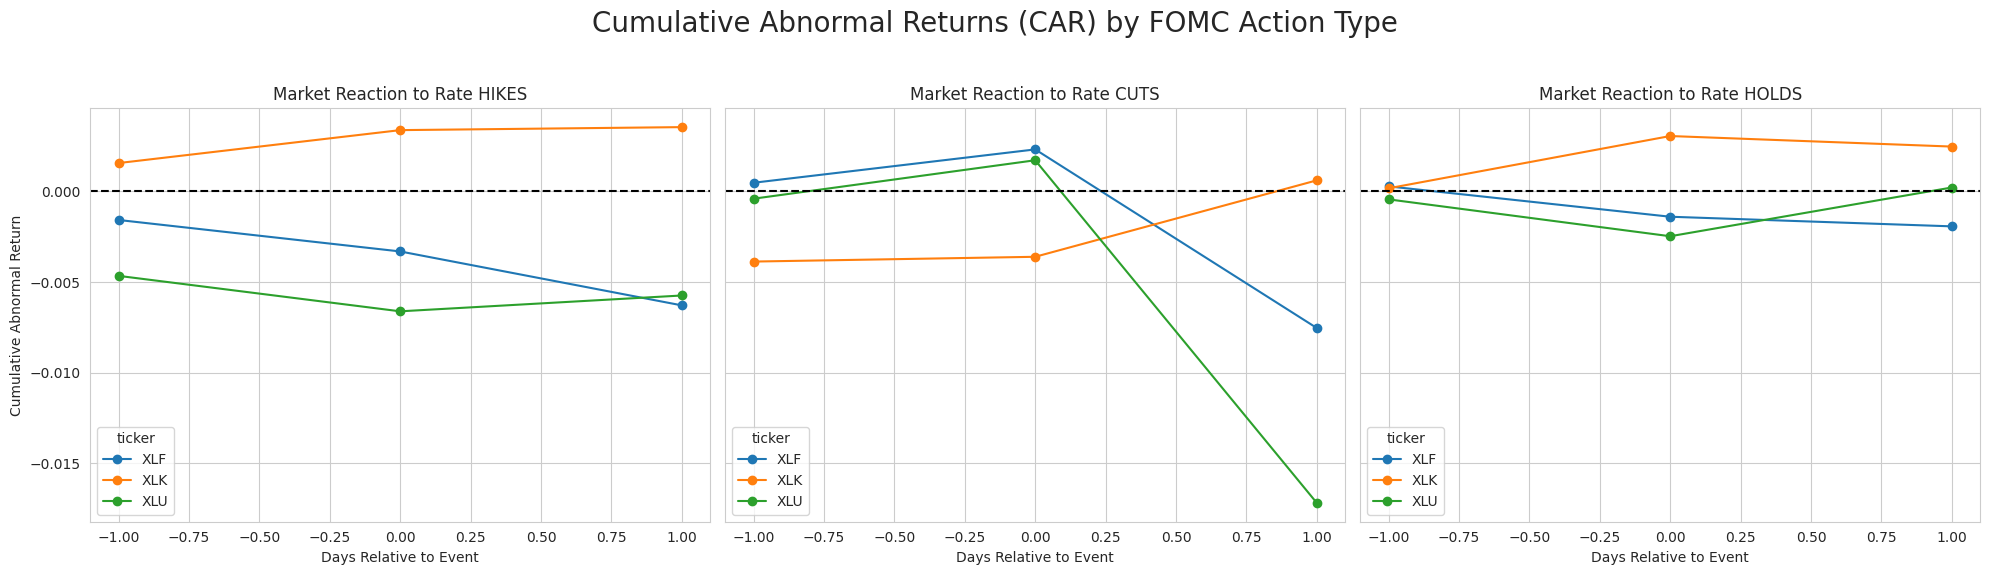

In [ ]:
# Run the analysis for each action type
print("Running analysis for RATE HIKES...")
car_hikes = run_event_study_for_action(pd.to_datetime(hike_dates), log_returns)

print("Running analysis for RATE CUTS...")
car_cuts = run_event_study_for_action(pd.to_datetime(cut_dates), log_returns)

print("Running analysis for RATE HOLDS...")
car_holds = run_event_study_for_action(pd.to_datetime(hold_dates), log_returns)

# Create subplots to visualize the results side-by-side
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
fig.suptitle('Cumulative Abnormal Returns (CAR) by FOMC Action Type', fontsize=20)

# Plot for Hikes
if not car_hikes.empty:
    car_hikes.plot(ax=axes[0], marker='o')
    axes[0].set_title('Market Reaction to Rate HIKES')
    axes[0].axhline(0, color='black', linestyle='--')
    axes[0].set_ylabel('Cumulative Abnormal Return')
    axes[0].set_xlabel('Days Relative to Event')

# Plot for Cuts
if not car_cuts.empty:
    car_cuts.plot(ax=axes[1], marker='o')
    axes[1].set_title('Market Reaction to Rate CUTS')
    axes[1].axhline(0, color='black', linestyle='--')
    axes[1].set_xlabel('Days Relative to Event')

# Plot for Holds
if not car_holds.empty:
    car_holds.plot(ax=axes[2], marker='o')
    axes[2].set_title('Market Reaction to Rate HOLDS')
    axes[2].axhline(0, color='black', linestyle='--')
    axes[2].set_xlabel('Days Relative to Event')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Perform t-tests for each action type to confirm statistical significance

def perform_t_tests_for_action(action_dates, action_name):
    """A helper function to run t-tests for a specific action's abnormal returns."""
    all_abnormal_returns = []
    # This is a condensed version of the analysis loop, just to get the raw abnormal returns
    for event_date in pd.to_datetime(action_dates):
        estimation_end = event_date - pd.Timedelta(days=30)
        estimation_start = estimation_end - pd.Timedelta(days=252)
        estimation_data = log_returns.loc[estimation_start:estimation_end]
        if len(estimation_data) < 20: continue
        for ticker in ANALYSIS_TICKERS:
            Y = estimation_data[ticker]
            X = sm.add_constant(estimation_data[MARKET_BENCHMARK])
            model = sm.OLS(Y, X, missing='drop').fit()
            alpha, beta = model.params
            for day in EVENT_WINDOW:
                current_date = event_date + pd.Timedelta(days=day)
                if current_date not in log_returns.index: continue
                actual_return = log_returns.loc[current_date, ticker]
                market_return = log_returns.loc[current_date, MARKET_BENCHMARK]
                expected_return = alpha + beta * market_return
                abnormal_return = actual_return - expected_return
                all_abnormal_returns.append({'ticker': ticker, 'day': day, 'abnormal_return': abnormal_return})

    action_ar_df = pd.DataFrame(all_abnormal_returns)
    if action_ar_df.empty:
        print(f"No data to test for {action_name}")
        return

    print(f"\\n--- T-Test Results for {action_name.upper()} ---")
    for ticker in ANALYSIS_TICKERS:
        print(f"\\n--- {ticker} ---")
        for day in EVENT_WINDOW:
            day_ar = action_ar_df[(action_ar_df['ticker'] == ticker) & (action_ar_df['day'] == day)]['abnormal_return']
            if len(day_ar) > 1:
                t_stat, p_value = stats.ttest_1samp(day_ar, popmean=0)
                print(f"Day {day: >2}: Avg AR = {day_ar.mean():.4%}, P-Value = {p_value:.4f}")

# Run the tests
perform_t_tests_for_action(hike_dates, "Rate Hikes")
perform_t_tests_for_action(cut_dates, "Rate Cuts")
perform_t_tests_for_action(hold_dates, "Rate Holds")

\n--- T-Test Results for RATE HIKES ---
\n--- XLK ---
Day -1: Avg AR = 0.1567%, P-Value = 0.4298
Day  0: Avg AR = 0.1817%, P-Value = 0.4536
Day  1: Avg AR = 0.0166%, P-Value = 0.9488
\n--- XLF ---
Day -1: Avg AR = -0.1573%, P-Value = 0.5180
Day  0: Avg AR = -0.1736%, P-Value = 0.4219
Day  1: Avg AR = -0.2975%, P-Value = 0.1157
\n--- XLU ---
Day -1: Avg AR = -0.4656%, P-Value = 0.2418
Day  0: Avg AR = -0.1956%, P-Value = 0.3813
Day  1: Avg AR = 0.0874%, P-Value = 0.8207
\n--- T-Test Results for RATE CUTS ---
\n--- XLK ---
Day -1: Avg AR = -0.3868%, P-Value = 0.2974
Day  0: Avg AR = 0.0263%, P-Value = 0.7803
Day  1: Avg AR = 0.4218%, P-Value = 0.0367
\n--- XLF ---
Day -1: Avg AR = 0.0481%, P-Value = 0.7423
Day  0: Avg AR = 0.1840%, P-Value = 0.5898
Day  1: Avg AR = -0.9854%, P-Value = 0.0964
\n--- XLU ---
Day -1: Avg AR = -0.0399%, P-Value = 0.9367
Day  0: Avg AR = 0.2121%, P-Value = 0.5772
Day  1: Avg AR = -1.8906%, P-Value = 0.5100
\n--- T-Test Results for RATE HOLDS ---
\n--- XLK ---


## 7. Synthesis and Overall Conclusion

In this final section, synthesize the findings from both the general and the advanced analysis to form a comprehensive conclusion.

1.  **Summarize Key Findings**: What is the single most important takeaway from this entire project?
2.  **Compare and Contrast**: How did the results from the advanced analysis (separating hikes, cuts, and holds) differ from the initial, general analysis? Did the advanced analysis confirm, contradict, or clarify your initial findings?
3.  **Final Answer**: Revisit the project's main question: **Do Federal Reserve (FOMC) interest rate announcements systematically cause abnormal stock returns in these sectors?** Provide your final, nuanced answer.
4.  **Future Work**: If you were to continue this project, what would be the next question you'd want to investigate? (e.g., analyze different sectors, look at the impact on bond ETFs, etc.).

## Solution

1. **Summarize Key Findings**: The single most important takeaway from this specific dataset is that the market's reaction to FOMC announcements was largely **counter-intuitive and statistically noisy**. Contrary to standard financial theory, the advanced analysis revealed that **rate hikes** were associated with **negative abnormal returns** for the **Financials (XLF)** sector (Day 1: -0.29%), likely indicating that recessionary fears outweighed the potential benefits of higher interest margins. Similarly, **rate cuts** did not boost the **Utilities (XLU)** sector as expected, but instead coincided with steep declines (Day 1: -1.89%), suggesting that these cuts occurred during periods of severe market stress (such as the onset of COVID-19) where "defensive" sectors provided little shelter.

2. **Compare and Contrast**: The advanced analysis clarified why the initial aggregate analysis showed no significant impact, though not in the way typically expected. Rather than finding "opposing forces" that cleanly canceled each other out, we found that market sentiment was largely **risk-off** or **idiosyncratic** across different policy actions. The "Cuts" category is particularly noteworthy; the lack of a positive reaction in defensive sectors highlights that during emergency cuts (e.g., March 2020), broad market panic can overshadow specific sector benefits. Comparing Hikes vs. Cuts reveals that neither policy action generated the predictable "textbook" rotation (e.g., into Banks for hikes, into Utilities for cuts) in this specific sample period.

3. **Final Answer**: Revisit the project's main question: **Do Federal Reserve (FOMC) interest rate announcements systematically cause abnormal stock returns in these sectors?** Based on this specific dataset, the answer is generally **no, with one key exception.** While the movements for Financials and Utilities were statistically insignificant (high p-values > 0.05), the **Technology sector (XLK)** showed a **statistically significant positive abnormal return of +0.42% (p=0.037)** on the day following a rate cut. This suggests that while "defensive" rotations failed during this period, the inverse relationship between interest rates and growth stock valuations held true.

4. **Future Work**: Given that *directional* returns generally proved difficult to predict, a valuable next step would be to analyze **market risk** instead. We could test the hypothesis that **market volatility** increases significantly after FOMC meetings, regardless of the direction of the price move. This would require applying volatility modeling techniques like GARCH. Additionally, incorporating **textual analysis** of FOMC minutes could help distinguish between "hawkish" and "dovish" hikes, as the *tone* of the announcement might be a better predictor of market reaction than the rate decision itself.